## Adaptive optimizers

In this seminar you will implement a logistic regression and train it using stochastic gradient descent modiffications, numpy and your brain.

In [1]:
#load our dakka
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Two-dimensional classification

To make things more intuitive, let's solve a 2D classification problem with syntetic data.

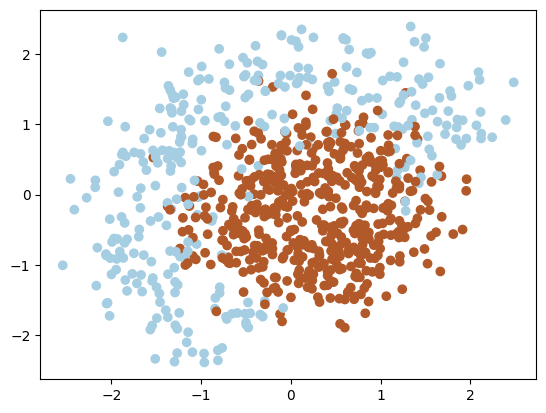

In [2]:
from sklearn import datasets, preprocessing
np.random.seed(42)
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]


plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.show()

In [3]:
print("X:\n{}\ny:\n{}".format(X[:3],y[:3]))

X:
[[1.20798057 0.0844994 ]
 [0.76121787 0.72510869]
 [0.55256189 0.51937292]]
y:
[1 1 1]


**Your task starts here**

Since the problem above isn't linearly separable, we add quadratic features to the classifier.

Implement this transformation in the __expand__ function __[1 point]__.

In [4]:
def expand(X):
    """
    Adds quadratic features.
    This function allows your linear model to make non-linear separation.

    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature1*feature2, 1]

    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """
    X_expanded = np.zeros((X.shape[0], 6))

    X_expanded[:, 0] = X[:, 0]

    # Feature 1
    X_expanded[:, 1] = X[:, 1]

    # Square of Feature 0
    X_expanded[:, 2] = X[:, 0]**2

    # Square of Feature 1
    X_expanded[:, 3] = X[:, 1]**2

    # Feature 0 multiplied by Feature 1
    X_expanded[:, 4] = X[:, 0] * X[:, 1]

    # Constant term
    X_expanded[:, 5] = 1

    return X_expanded

In [5]:
#simple test on random numbers
#[all 8 random numbers are 100% random :P]
dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])

#call your expand function
dummy_expanded = expand(dummy_X)

#what it should have returned:   x0       x1       x0^2     x1^2     x0*x1    1
dummy_expanded_ans = np.array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
                               [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
                               [ 2.61  , -1.28  ,  6.8121,  1.6384, -3.3408,  1.    ],
                               [-0.59  ,  2.1   ,  0.3481,  4.41  , -1.239 ,  1.    ]])

#tests
assert isinstance(dummy_expanded,np.ndarray), "please make sure you return numpy array"
assert dummy_expanded.shape==dummy_expanded_ans.shape, "please make sure your shape is correct"
assert np.allclose(dummy_expanded,dummy_expanded_ans,1e-3), "Something's out of order with features"

print("Seems legit!")


Seems legit!


### Logistic regression (4 pts)
Now, let's write function that predicts class given X as in logistic regression.

The math should look like this:

$$ P(y| \vec x, \vec w) = \sigma(\vec x \cdot \vec w )$$

where x represents features, w are weights and $$\sigma(a) = {1 \over {1+e^{-a}}}$$

We shall omit $ \vec {arrows} $ in further formulae for simplicity.

In [6]:
def classify(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x), see description above

    __don't forget to expand X inside classify and other functions__

    :param X: feature matrix X of shape [n_samples,2] (non-exanded)
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """

    X_expanded = expand(X)
    a = np.dot(X_expanded, w)
    p = 1 / (1 + np.exp(-a))

    return p

In [7]:
#sample usage / test just as the previous one
dummy_weights = np.linspace(-1,1,6)

dummy_probs = classify(dummy_X,dummy_weights)

dummy_answers = np.array([ 0.73105858,  0.450166  ,  0.02020883,  0.59844257])

assert isinstance(dummy_probs,np.ndarray), "please return np.array"
assert dummy_probs.shape == dummy_answers.shape, "please return an 1-d vector with answers for each object"
assert np.allclose(dummy_probs,dummy_answers,1e-3), "There's something non-canonic about how probabilties are computed"

The loss you should try to minimize is the Logistic Loss aka crossentropy aka negative log-likelihood:

$$ L =  - {1 \over N} \sum_i {y_i \cdot log P(y_i|x_i,w) + (1-y_i) \cdot log (1-P(y_i|x_i,w))}$$



In [8]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector y [n_samples] of +1/0,
    and weight vector w [6], compute scalar loss function using formula above.
    """

    # predicted probabilities
    #p = classify(X, w)
    p = np.clip(classify(X, w), 1e-10, 1-1e-10)

    # individual loss - {y_i \cdot log P(y_i|x_i,w) + (1-y_i) \cdot log (1-P(y_i|x_i,w))}
    loss_samples = -y * np.log(p) - (1 - y) * np.log(1 - p)

    # average loss
    L = np.mean(loss_samples)

    return L

In [9]:
dummy_y = np.array([0,1,0,1])
dummy_loss = compute_loss(dummy_X,dummy_y,dummy_weights)

assert np.allclose(dummy_loss,0.66131), "something wrong with loss"

Since we train our model with gradient descent, we gotta compute gradients.

To be specific, we need a derivative of loss function over each weight [6 of them].

$$ \nabla L = {\partial L \over \partial w} = ...$$

No, we won't be giving you the exact formula this time. Instead, try figuring out a derivative with pen and paper.

As usual, we've made a small test for you, but if you need more, feel free to check your math against finite differences (estimate how L changes if you shift w by $10^{-5}$ or so).

In [10]:

def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector y [n_samples] of +1/0,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """

    X_expanded = expand(X)
    p = classify(X, w)
    #gradient
    grad = np.dot((p - y), X_expanded) / len(y)

    return grad

In [11]:
#tests
dummy_grads = compute_grad(dummy_X,dummy_y,dummy_weights)

#correct answers in canonic form
dummy_grads_ans = np.array([-0.06504252, -0.21728448, -0.1379879 , -0.43443953,  0.107504  , -0.05003101])

assert isinstance(dummy_grads,np.ndarray)
assert dummy_grads.shape == (6,), "must return a vector of gradients for each weight"
assert len(set(np.round(dummy_grads/dummy_grads_ans,3))), "gradients are wrong"
assert np.allclose(dummy_grads,dummy_grads_ans,1e-3), "gradients are off by a coefficient"

Here's an auxiliary function that visualizes the predictions

In [12]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, history):
    """draws classifier prediction with matplotlib magic"""
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.subplot(1,2,2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

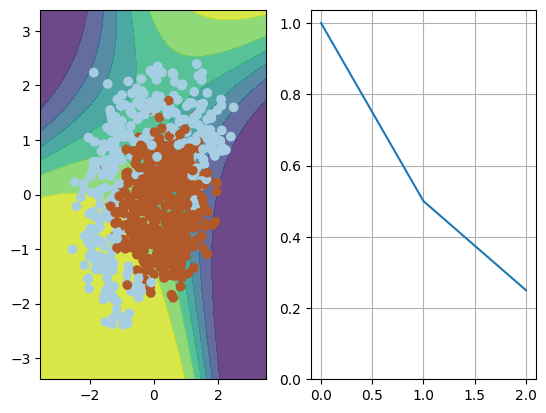

In [13]:
visualize(X,y,dummy_weights,[1,0.5,0.25],)

### Training [1 point]
In this section, we'll use the functions you wrote to train our classifier using stochastic gradient descent.

Try to find an optimal learning rate for gradient descent for the given batch size.

**Don't change the batch size!**

In [14]:
np.random.seed(42)

w_init = np.array([0,0,0,0,0,1])

alphas = np.arange(0.01, 1.0, 0.01)
best_alpha = alphas[0]
lowest_loss = float('inf')

n_iter = 50
batch_size = 4

for alpha in alphas:
    w = w_init.copy()
    total_loss = 0
    for i in range(n_iter):
        ind = np.random.choice(X.shape[0], batch_size)
        loss_i = compute_loss(X, y, w)
        total_loss += loss_i
        w = w - alpha * compute_grad(X[ind,:], y[ind], w)

    avg_loss = total_loss / n_iter
    if avg_loss < lowest_loss:
        best_alpha = alpha
        lowest_loss = avg_loss

print(f"Best learning rate: {best_alpha} with average loss: {lowest_loss}")

Best learning rate: 0.98 with average loss: 0.29854502900978547


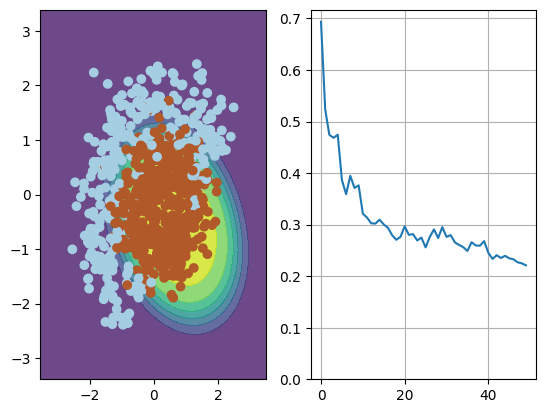

<Figure size 640x480 with 0 Axes>

In [15]:
w = np.array([0,0,0,0,0,1])

np.random.seed(42)
alpha = 0.98
n_iter = 50

batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)

    w = w - alpha * compute_grad(X[ind,:], y[ind], w)


visualize(X, y, w, loss)
plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values. __[2 points]__

In [16]:
np.random.seed(42)
w_init = np.array([0,0,0,0,0,1])

alphas = np.arange(0.01, 1.00, 0.01)
mus = np.arange(0.01, 1.00, 0.01)

best_alpha = alphas[0]
best_mu = mus[0]
lowest_loss = float('inf')

n_iter = 50
batch_size = 4

for alpha in alphas:
    for mu in mus:

        w = w_init.copy()
        v = np.zeros_like(w)

        total_loss = 0
        for i in range(n_iter):
            ind = np.random.choice(X.shape[0], batch_size)
            loss_i = compute_loss(X, y, w)
            total_loss += loss_i

            gradient = compute_grad(X[ind,:], y[ind], w)
            v = mu * v - alpha * gradient
            w = w + v

        avg_loss = total_loss / n_iter
        if avg_loss < lowest_loss:
            best_alpha = alpha
            best_mu = mu
            lowest_loss = avg_loss

print(f"Best learning rate: {best_alpha}, Best momentum: {best_mu} with average loss: {lowest_loss}")


Best learning rate: 0.87, Best momentum: 0.54 with average loss: 0.2705103603979088


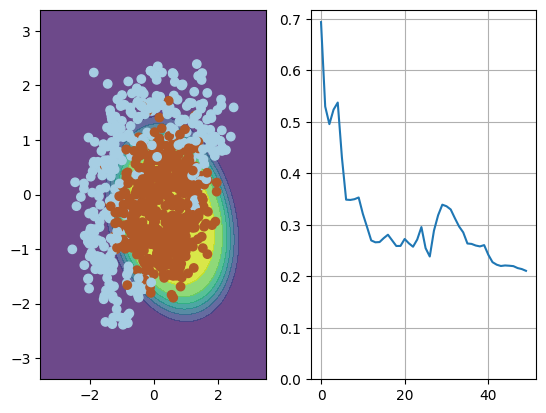

<Figure size 640x480 with 0 Axes>

In [17]:
np.random.seed(42)
w = np.array([0,0,0,0,0,1])

alpha = 0.87 # learning rate. Please change.
mu    = 0.54 # momentum. Please change.

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)

w = w_init.copy()
v = np.zeros_like(w)

plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)

    gradient = compute_grad(X[ind,:], y[ind], w)
    v = mu * v - alpha * gradient
    w = w + v

visualize(X, y, w, loss)
plt.clf()

Implement RMSPROP algorithm __[2 points]__


In [23]:
np.random.seed(42)
w_init = np.array([0,0,0,0,0,1])

alphas = np.arange(0.01, 1.0, 0.01)
betas = np.arange(0.01, 1.0, 0.01)
best_alpha = alphas[0]
best_beta = betas[0]
lowest_loss = float('inf')

epsilon = 1e-6

n_iter = 50
batch_size = 4

for alpha in alphas:
  for beta in betas:
    w = w_init.copy()
    mean_squared_norm = np.zeros_like(w)
    total_loss = 0
    for i in range(n_iter):
        ind = np.random.choice(X.shape[0], batch_size)
        loss_i = compute_loss(X, y, w)
        total_loss += loss_i

        gradient = compute_grad(X[ind,:], y[ind], w)
        mean_squared_norm = beta * mean_squared_norm + (1 - beta) * gradient**2
        w = w - alpha / (np.sqrt(mean_squared_norm) + epsilon) * gradient

    avg_loss = total_loss / n_iter
    if avg_loss < lowest_loss:
        best_alpha = alpha
        best_beta = beta
        lowest_loss = avg_loss

print(f"Best learning rate (alpha): {best_alpha} Best decay rate (beta): {best_beta}  with average loss: {lowest_loss}")


Best learning rate (alpha): 0.28 Best decay rate (beta): 0.9600000000000001  with average loss: 0.2689917559635174


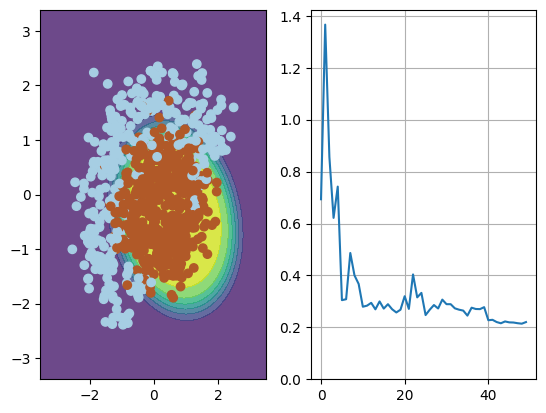

<Figure size 640x480 with 0 Axes>

In [22]:
np.random.seed(42)
w = np.array([0,0,0,0,0,1])

alpha = 0.28
beta = 0.96
epsilon = 1e-6
mean_squared_norm = np.zeros_like(w)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)

    gradient = compute_grad(X[ind,:], y[ind], w)
    mean_squared_norm = beta * mean_squared_norm + (1 - beta) * gradient**2
    w = w - alpha / (np.sqrt(mean_squared_norm) + epsilon) * gradient

visualize(X, y, w, loss)
plt.clf()


Which optimization method you consider the best? Type your answer in the cell below

Hard to say which is the best for the current dataset, since it is not sparse:

SGD shakes but converges more slowly.

SGD with momentum is smoother but somehow has the jump while converges faster.

RMSProp converges much faster but shakes more.

If we care about speed of convergence and final loss then RMSProp is the best here.

# Bonus quest
Try the same thing for Adagrad, Adam and anything else you find suitable.

_Each new adaptive optimizer is worth 2 points!_

Adagrad

In [26]:
np.random.seed(42)
w_init = np.array([0,0,0,0,0,1])
epsilon = 1e-6

alphas = np.arange(0.01, 1.00, 0.01)
best_alpha = alphas[0]
lowest_loss = float('inf')

n_iter = 50
batch_size = 4

for alpha in alphas:
    w = w_init.copy()
    accumulated_squared_gradient = np.zeros_like(w, dtype=np.float64)
    total_loss = 0

    for i in range(n_iter):
        ind = np.random.choice(X.shape[0], batch_size)
        current_loss = compute_loss(X, y, w)
        total_loss += current_loss

        gradient = compute_grad(X[ind,:], y[ind], w)
        accumulated_squared_gradient += gradient**2
        w = w - alpha / (np.sqrt(accumulated_squared_gradient) + epsilon) * gradient

    average_loss = total_loss / n_iter
    if average_loss < lowest_loss:
        lowest_loss = average_loss
        best_alpha = alpha

print(f"Optimal alpha: {best_alpha} with average loss: {lowest_loss} ")


Optimal alpha: 0.7100000000000001 with average loss: 0.27814036042369844 


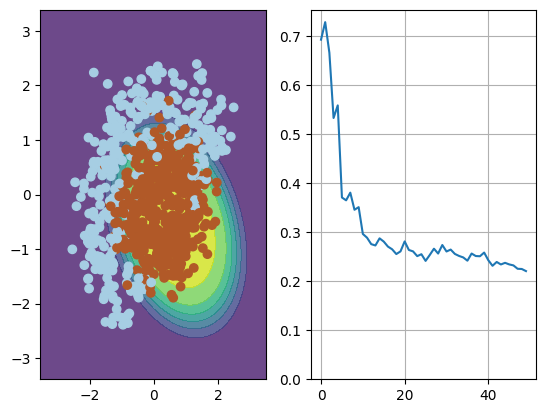

<Figure size 640x480 with 0 Axes>

In [27]:
np.random.seed(42)
w = np.array([0,0,0,0,0,1])

alpha = 0.71
epsilon = 1e-6
accumulated_squared_gradient = np.zeros_like(w, dtype=np.float64)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)

    gradient = compute_grad(X[ind,:], y[ind], w)
    accumulated_squared_gradient += gradient**2
    w = w - alpha / (np.sqrt(accumulated_squared_gradient) + epsilon) * gradient

visualize(X, y, w, loss)
plt.clf()


Adam

In [29]:
np.random.seed(42)
w_init = np.array([0,0,0,0,0,1])
epsilon = 1e-8


alphas = np.arange(0.01, 1.00, 0.01)
beta1s = np.arange(0.8, 0.999, 0.01)
beta2s = np.arange(0.8, 0.999, 0.01)

best_alpha = alphas[0]
best_beta1 = beta1s[0]
best_beta2 = beta2s[0]
lowest_loss = float('inf')

n_iter = 50
batch_size = 4

for alpha in alphas:
    for beta1 in beta1s:
        for beta2 in beta2s:
            w = w_init.copy()
            m = np.zeros_like(w, dtype=np.float64)
            v = np.zeros_like(w, dtype=np.float64)
            total_loss = 0

            for i in range(n_iter):
                ind = np.random.choice(X.shape[0], batch_size)
                current_loss = compute_loss(X, y, w)
                total_loss += current_loss

                gradient = compute_grad(X[ind,:], y[ind], w)

                m = beta1 * m + (1 - beta1) * gradient
                v = beta2 * v + (1 - beta2) * gradient**2

                m_hat = m / (1 - beta1**(i+1))
                v_hat = v / (1 - beta2**(i+1))

                w = w - alpha * m_hat / (np.sqrt(v_hat) + epsilon)

            average_loss = total_loss / n_iter
            if average_loss < lowest_loss:
                lowest_loss = average_loss
                best_alpha = alpha
                best_beta1 = beta1
                best_beta2 = beta2

print(f"Optimal alpha: {best_alpha}")
print(f"Optimal beta1: {best_beta1}")
print(f"Optimal beta2: {best_beta2}")
print(f"Average loss: {lowest_loss} ")

Optimal alpha: 0.39
Optimal beta1: 0.8700000000000001
Optimal beta2: 0.9700000000000002
Average loss: 0.2612102574754794 


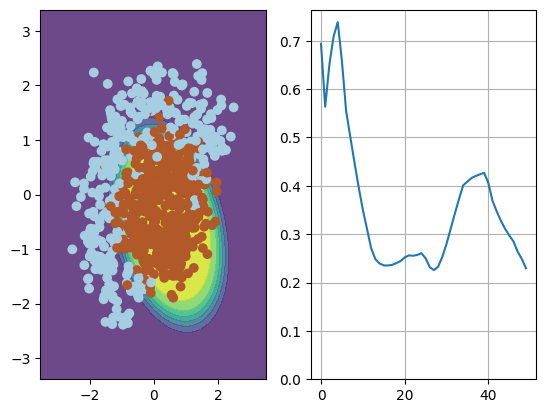

<Figure size 640x480 with 0 Axes>

In [30]:
np.random.seed(42)
w = np.array([0,0,0,0,0,1])

# Hyperparameters
alpha = 0.39
beta1 = 0.87
beta2 = 0.97
epsilon = 1e-8

# First moment vector
m = np.zeros_like(w, dtype=np.float64)
# Second moment vector
v = np.zeros_like(w, dtype=np.float64)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)

    gradient = compute_grad(X[ind,:], y[ind], w)

    # Update biased first moment estimate
    m = beta1 * m + (1 - beta1) * gradient
    # Update biased second raw moment estimate
    v = beta2 * v + (1 - beta2) * gradient**2
    # Compute bias-corrected first moment estimate
    m_hat = m / (1 - beta1**(i+1))
    # Compute bias-corrected second raw moment estimate
    v_hat = v / (1 - beta2**(i+1))
    # Update weights
    w = w - alpha * m_hat / (np.sqrt(v_hat) + epsilon)

visualize(X, y, w, loss)
plt.clf()
